In [91]:
# Team 69
# Dillon Blake 1524907
# Andrea Delahaye 1424289
# Yue Peng 958289
# Jeff Phan 1577799
# Alistair Wilcox 212544

import requests
import pandas as pd
import os
import json
from datetime import datetime
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt 
import pickle
import seaborn as sns
import math

# Constants

In [92]:
URL = 'http://172.26.135.52:9090/'
HEADERS = {'HOST': 'fission'}
METRIC = 'Particles'
weather_columns = ['Temp', 'Humid', 'WindSpeed', 'Rain']

# Get list of stations

In [93]:
ret = requests.get(os.path.join(URL, 'stations'), headers=HEADERS)
station_resp = json.loads(ret.text)
try:
    if station_resp['Status'] == 200:
        station_list = [x['Station ID'] for x in station_resp['Data']]
except:
    print('Error receiving response from server')

# Define functions to get EPA data

In [94]:
def filter_metric(results: list[dict], metric: str, station: str) -> list[dict]:
    """
    Filter specific metric and add station tag
    
    @param results is the raw data from ES
    @param metric is the metric to filter
    @param station is the station number as a string
    @return a list of dictionaries of data
    """
    out = []
    for result in results:
        try:
            if result['_source']['measure_name'] == metric:
                out.append(result['_source'])
        except:
            continue
    for o in out:
        o['Station'] = station
    return out

def get_readings(station: str, metric: str) -> list[dict]:
    """
    Get the readings from a station for a specific metric

    @param station is the station number to query
    @param metric is the metric to filter
    @return list of dicts of filtered data
    """
    out = []
    # Get station location with radius of 30
    ret = requests.get(os.path.join(URL, 'epa', str(station), '1000', '30'), headers=HEADERS)
    # Load response as json
    try:
        epa_resp_data = json.loads(ret.text)
        if epa_resp_data['Status'] == 200:
            out.extend(epa_resp_data['Data'])
        else:
            return []
    except:
        return []
    while 'Token' in epa_resp_data.keys() and epa_resp_data['Token'] != 'END' and len(epa_resp_data['Data']) != 0:
        ret = requests.get(os.path.join(URL, 'stream', epa_resp_data['Token']), headers=HEADERS)
        try:
            epa_resp_data = json.loads(ret.text)
            out.extend(epa_resp_data['Data'])
        except:
            break
    return filter_metric(out, metric, station)
    

# Define function to get weather

In [95]:
def get_weather(station: str, start: int, end: int) -> list[dict]:
    """
    Get the weather from a station for a given year range

    @param station is the string of the station number
    @param start is the start year
    @param end is the end year
    @return list of dicts of weather
    """
    ret = requests.get(os.path.join(URL, 'weather', station, str(start), str(end)), headers=HEADERS)
    try:
        weather_data_json = json.loads(ret.text)
        if weather_data_json['Status'] == 200:
            weather_data = weather_data_json['Data']
            weather_list = [weather_data['hits']['hits'][i]['_source'] for i in range(len(weather_data['hits']['hits']))]
            for item in weather_list:
                item['Station'] = station
            return weather_list
    except:
        pass
    return []

# Get EPA data

In [96]:
epa_df = None
for station in station_list:
    temp_df = pd.DataFrame.from_records(get_readings(station, METRIC))
    if epa_df is None:
        epa_df = temp_df.copy()
    else:
        epa_df = pd.concat([epa_df, temp_df])

# Clean EPA data

In [97]:
epa_df['location'] = epa_df['location'].apply(lambda x: (x[0], x[1]))
epa_df = epa_df.drop_duplicates(subset=epa_df.columns.difference(['station']))
epa_df['start'] = epa_df['start'].apply(lambda x: datetime.strptime(x.split('T')[0], '%Y-%m-%d'))
epa_df['end'] = epa_df['end'].apply(lambda x: datetime.strptime(x.split('T')[0], '%Y-%m-%d'))
epa_df['Date'] = epa_df['start']

# Get Weather

In [98]:
min_year = epa_df['start'].min().year
max_year = epa_df['start'].max().year + 1
weather_df = None
for station in epa_df['Station'].unique():
    ret = requests.get(os.path.join(URL, 'weather', str(station), str(min_year), str(max_year)))
    try:
        weather_json = json.loads(ret.text)
        if weather_json['Status'] == 200:
            if weather_df is None:
                weather_df = pd.DataFrame.from_records(weather_json['Data'])
                weather_df['Station'] = station
            else:
                temp_df = pd.DataFrame.from_records(weather_json['Data'])
                temp_df['Station'] = station
                weather_df = pd.concat([weather_df, temp_df])
    except:
        continue

# Create combined data for training

In [99]:
weather_df['Date'] = weather_df['Date'].apply(lambda x: datetime.strptime(x.split('T')[0], '%d/%m/%Y'))
weather_df['Max Temp'] = pd.to_numeric(weather_df['Max Temp'])
weather_df['Min Temp'] = pd.to_numeric(weather_df['Min Temp'])
weather_df['Max Humid'] = pd.to_numeric(weather_df['Max Humid'])
weather_df['Min Humid'] = pd.to_numeric(weather_df['Min Humid'])
weather_df['WindSpeed'] = pd.to_numeric(weather_df['WindSpeed'])
weather_df['Rain'] = pd.to_numeric(weather_df['Rain'])
weather_df['Temp'] = (weather_df['Min Temp'] + weather_df['Max Temp']) / 2.0
weather_df['Humid'] = (weather_df['Min Humid'] + weather_df['Max Humid']) / 2.0
weather_df = weather_df[weather_df['Temp'] > -50]
weather_df = weather_df[weather_df['WindSpeed'] >= 0]
weather_df = weather_df[weather_df['Humid'] >= 0]
weather_df = weather_df[weather_df['Rain'] >= 0]
combined_df = pd.merge(epa_df, weather_df, on=['Date', 'Station'], how='inner')
combined_df[METRIC] = combined_df['value']
weather_columns = ['Temp', 'Humid', 'WindSpeed', 'Rain']

# Create model

In [100]:
model = LinearRegression()
model.fit(combined_df[weather_columns], combined_df['value'])
with open('./epa_model', 'wb') as file:
    pickle.dump(model, file)

# Interactive 

In [103]:
from ipywidgets import interact 
def display(Metric): 
    plt.scatter(combined_df[Metric], combined_df[METRIC])
    x_range = combined_df[Metric].max() - combined_df[Metric].min()
    start_x = math.floor(combined_df[Metric].min())
    interval = x_range / 10
    ticks = []
    for n in range(11):
        ticks.append(start_x + n * interval)
    plt.xticks(ticks)
    plt.xlabel(Metric)
    plt.ylabel(METRIC)
    plt.show()
    return Metric
interact(display, Metric=weather_columns)

The history saving thread hit an unexpected error (OperationalError('attempt to write a readonly database')).History will not be written to the database.


interactive(children=(Dropdown(description='Metric', options=('Temp', 'Humid', 'WindSpeed', 'Rain'), value='Te…

<function __main__.display(Metric)>

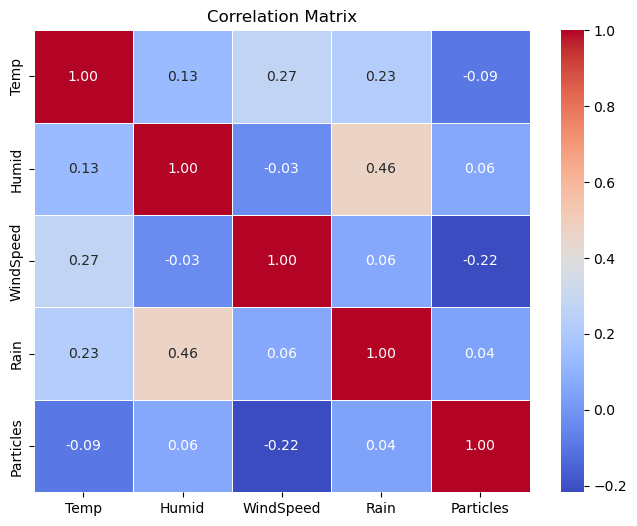

In [102]:
correlation_columns = weather_columns.copy()
correlation_columns.append(METRIC)
corr_table_pers = combined_df[correlation_columns].corr(method='pearson')
plt.figure(figsize=(8, 6))
sns.heatmap(corr_table_pers, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Correlation Matrix')
plt.show()